<a href="https://colab.research.google.com/github/BradenEberhard/TimeSeries/blob/main/Time_Series_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. only use last hidden layer
2. hyper tune, lr, batch size, num layers, training window
3. TODO first! get a submission in!
4. add attention
5. maybe try a transformer

In [1]:
import os
import time
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb
import random
import datetime

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
train = pd.read_csv('./drive/MyDrive/Models/Time Series/train.csv', parse_dates=[0])
test = pd.read_csv('./drive/MyDrive/Models/Time Series/test.csv', parse_dates=[0], index_col='id')

In [4]:
def get_all_items_seq(train = train, tw = 50):
  scaler = MinMaxScaler()
  new_df = train.sort_values(['date', 'store', 'item'], ascending=[True, True, True])
  new_df.sales = scaler.fit_transform(np.array(new_df.sales).reshape(-1,1))
  new_df = torch.FloatTensor([new_df[new_df.date == x].sales for x in np.unique(new_df.date)])
  inout_seq = []
  L = len(new_df)
  for i in tqdm(range(L - tw)):
    train_seq = new_df[i:i+tw,:]
    train_label = new_df[i+tw:i+tw+1,:]
    inout_seq.append((train_seq, train_label))
  return inout_seq, scaler

In [5]:
class inputs_dataset(Dataset):

    def __init__(self, tensor):

        self.tensor = tensor

    def __len__(self):
        return len(self.tensor)

    def __getitem__(self, idx):
        return self.tensor[idx]

    def check(self, idx):
      return self.tensor[idx]




In [46]:
class LSTM(nn.Module):
  def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, num_layers=1, batch_size = 1, tw = 50):
    super().__init__()
    self.hidden_layer_size = hidden_layer_size
    self.batch_size = batch_size
    self.tw = tw
    self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first = True)

    self.linear = nn.Linear(hidden_layer_size, output_size)

    self.hidden_cell = (torch.zeros(num_layers,batch_size,self.hidden_layer_size).cuda(),
                        torch.zeros(num_layers,batch_size,self.hidden_layer_size).cuda())
    
  def forward(self, input_seq):
    lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
    predictions = self.linear(lstm_out.view(self.tw, -1))
    return predictions[-1]

In [47]:
PATH = './drive/MyDrive/Models/Time Series/LSTM.all_stores_and_items.50_window.1_layers.v0'
LOAD_MODEL = False
SAVE_MODEL = True
TRAIN_WINDOW = 100
BATCH_SIZE = 1
NUM_LAYERS = 1

sequence, scaler = get_all_items_seq(tw=TRAIN_WINDOW)
my_data = inputs_dataset(sequence)
my_loader = DataLoader(my_data, batch_size=BATCH_SIZE, shuffle=True)

model = LSTM(input_size=500, hidden_layer_size = 200, output_size=500, num_layers=NUM_LAYERS, batch_size=BATCH_SIZE, tw=TRAIN_WINDOW).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
epochs = 100

if LOAD_MODEL:
  checkpoint = torch.load(PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  losses = checkpoint['losses']
else:
  epoch = 0
  losses = []
for i in tqdm(range(epochs)):
  for seq, labels in my_loader:

    seq = seq.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    model.hidden_cell = (torch.zeros(NUM_LAYERS,BATCH_SIZE,model.hidden_layer_size).cuda(),
                         torch.zeros(NUM_LAYERS,BATCH_SIZE,model.hidden_layer_size).cuda())

    y_pred = model(seq)
    single_loss = criterion(y_pred, labels)
    single_loss.backward()
    losses.append(single_loss.item())
    optimizer.step()

  if (i%10 == 0):
    print('losses: ' + str(losses[-1]) + ' epoch: ' + str(epoch + i))
    torch.save({
        'epoch': epoch + i,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        }, PATH)











100%|██████████| 1726/1726 [00:00<00:00, 122284.57it/s]










  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1, 500])) that is different to the input size (torch.Size([500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)










  1%|          | 1/100 [00:07<11:50,  7.18s/it]

losses: 0.0007964529213495553 epoch: 0












  2%|▏         | 2/100 [00:14<11:41,  7.16s/it]









  3%|▎         | 3/100 [00:21<11:31,  7.13s/it]









  4%|▍         | 4/100 [00:28<11:21,  7.10s/it]









  5%|▌         | 5/100 [00:35<11:08,  7.04s/it]









  6%|▌         | 6/100 [00:42<10:58,  7.00s/it]









  7%|▋         | 7/100 [00:49<10:49,  6.99s/it]









  8%|▊         | 8/100 [00:56<10:44,  7.00s/it]









  9%|▉         | 9/100 [01:03<10:37,  7.00s/it]









 10%|█         | 10/100 [01:10<10:30,  7.00s/it]









 11%|█         | 11/100 [01:17<10:27,  7.06s/it]

losses: 0.002425010083243251 epoch: 10












 12%|█▏        | 12/100 [01:24<10:24,  7.10s/it]









 13%|█▎        | 13/100 [01:31<10:17,  7.10s/it]









 14%|█▍        | 14/100 [01:38<10:12,  7.12s/it]









 15%|█▌        | 15/100 [01:45<10:05,  7.13s/it]









 16%|█▌        | 16/100 [01:53<09:57,  7.12s/it]









 17%|█▋        | 17/100 [02:00<09:47,  7.08s/it]









 18%|█▊        | 18/100 [02:06<09:35,  7.02s/it]









 19%|█▉        | 19/100 [02:13<09:26,  7.00s/it]









 20%|██        | 20/100 [02:20<09:18,  6.98s/it]









 21%|██        | 21/100 [02:27<09:10,  6.97s/it]

losses: 0.0009669174905866385 epoch: 20












 22%|██▏       | 22/100 [02:34<09:04,  6.98s/it]









 23%|██▎       | 23/100 [02:41<08:54,  6.94s/it]









 24%|██▍       | 24/100 [02:48<08:48,  6.95s/it]









 25%|██▌       | 25/100 [02:55<08:42,  6.96s/it]









 26%|██▌       | 26/100 [03:02<08:35,  6.96s/it]









 27%|██▋       | 27/100 [03:09<08:26,  6.94s/it]









 28%|██▊       | 28/100 [03:16<08:18,  6.92s/it]









 29%|██▉       | 29/100 [03:23<08:10,  6.91s/it]









 30%|███       | 30/100 [03:30<08:05,  6.93s/it]









 31%|███       | 31/100 [03:37<08:02,  6.99s/it]

losses: 0.0012136786244809628 epoch: 30












 32%|███▏      | 32/100 [03:44<07:56,  7.01s/it]









 33%|███▎      | 33/100 [03:51<07:48,  6.99s/it]









 34%|███▍      | 34/100 [03:58<07:41,  6.99s/it]









 35%|███▌      | 35/100 [04:05<07:32,  6.96s/it]









 36%|███▌      | 36/100 [04:12<07:25,  6.96s/it]









 37%|███▋      | 37/100 [04:19<07:18,  6.96s/it]









 38%|███▊      | 38/100 [04:26<07:10,  6.94s/it]









 39%|███▉      | 39/100 [04:32<07:02,  6.93s/it]









 40%|████      | 40/100 [04:39<06:56,  6.95s/it]









 41%|████      | 41/100 [04:46<06:50,  6.96s/it]

losses: 0.0013824502239003778 epoch: 40












 42%|████▏     | 42/100 [04:53<06:43,  6.96s/it]









 43%|████▎     | 43/100 [05:00<06:34,  6.92s/it]









 44%|████▍     | 44/100 [05:07<06:27,  6.92s/it]









 45%|████▌     | 45/100 [05:14<06:20,  6.92s/it]









 46%|████▌     | 46/100 [05:21<06:14,  6.93s/it]









 47%|████▋     | 47/100 [05:28<06:08,  6.95s/it]









 48%|████▊     | 48/100 [05:35<06:01,  6.96s/it]









 49%|████▉     | 49/100 [05:42<05:55,  6.97s/it]









 50%|█████     | 50/100 [05:49<05:48,  6.97s/it]









 51%|█████     | 51/100 [05:56<05:42,  6.98s/it]

losses: 0.0013307951157912612 epoch: 50












 52%|█████▏    | 52/100 [06:03<05:35,  7.00s/it]









 53%|█████▎    | 53/100 [06:10<05:28,  6.99s/it]









 54%|█████▍    | 54/100 [06:17<05:20,  6.96s/it]









 55%|█████▌    | 55/100 [06:24<05:13,  6.96s/it]









 56%|█████▌    | 56/100 [06:31<05:06,  6.96s/it]









 57%|█████▋    | 57/100 [06:38<04:59,  6.97s/it]









 58%|█████▊    | 58/100 [06:45<04:50,  6.91s/it]









 59%|█████▉    | 59/100 [06:51<04:41,  6.87s/it]









 60%|██████    | 60/100 [06:58<04:34,  6.86s/it]









 61%|██████    | 61/100 [07:05<04:26,  6.83s/it]

losses: 0.0010133803589269519 epoch: 60












 62%|██████▏   | 62/100 [07:12<04:18,  6.81s/it]









 63%|██████▎   | 63/100 [07:18<04:10,  6.78s/it]









 64%|██████▍   | 64/100 [07:25<04:05,  6.82s/it]









 65%|██████▌   | 65/100 [07:32<04:00,  6.86s/it]









 66%|██████▌   | 66/100 [07:39<03:52,  6.85s/it]









 67%|██████▋   | 67/100 [07:46<03:44,  6.80s/it]









 68%|██████▊   | 68/100 [07:53<03:37,  6.79s/it]









 69%|██████▉   | 69/100 [07:59<03:30,  6.78s/it]









 70%|███████   | 70/100 [08:06<03:22,  6.75s/it]









 71%|███████   | 71/100 [08:13<03:15,  6.73s/it]

losses: 0.0007825529901310802 epoch: 70












 72%|███████▏  | 72/100 [08:19<03:08,  6.74s/it]









 73%|███████▎  | 73/100 [08:26<03:01,  6.73s/it]









 74%|███████▍  | 74/100 [08:33<02:54,  6.72s/it]









 75%|███████▌  | 75/100 [08:40<02:48,  6.74s/it]









 76%|███████▌  | 76/100 [08:46<02:41,  6.74s/it]









 77%|███████▋  | 77/100 [08:53<02:34,  6.73s/it]









 78%|███████▊  | 78/100 [09:00<02:27,  6.70s/it]









 79%|███████▉  | 79/100 [09:06<02:20,  6.70s/it]









 80%|████████  | 80/100 [09:13<02:13,  6.67s/it]









 81%|████████  | 81/100 [09:20<02:06,  6.67s/it]

losses: 0.0011789004784077406 epoch: 80












 82%|████████▏ | 82/100 [09:26<01:59,  6.65s/it]









 83%|████████▎ | 83/100 [09:33<01:52,  6.65s/it]









 84%|████████▍ | 84/100 [09:40<01:46,  6.65s/it]









 85%|████████▌ | 85/100 [09:46<01:39,  6.66s/it]









 86%|████████▌ | 86/100 [09:53<01:32,  6.63s/it]









 87%|████████▋ | 87/100 [09:59<01:25,  6.60s/it]









 88%|████████▊ | 88/100 [10:06<01:19,  6.59s/it]









 89%|████████▉ | 89/100 [10:13<01:12,  6.60s/it]









 90%|█████████ | 90/100 [10:19<01:05,  6.60s/it]









 91%|█████████ | 91/100 [10:26<00:59,  6.62s/it]

losses: 0.0014270319370552897 epoch: 90












 92%|█████████▏| 92/100 [10:32<00:52,  6.62s/it]









 93%|█████████▎| 93/100 [10:39<00:46,  6.61s/it]









 94%|█████████▍| 94/100 [10:46<00:39,  6.61s/it]









 95%|█████████▌| 95/100 [10:52<00:33,  6.61s/it]









 96%|█████████▌| 96/100 [10:59<00:26,  6.61s/it]









 97%|█████████▋| 97/100 [11:05<00:19,  6.63s/it]









 98%|█████████▊| 98/100 [11:12<00:13,  6.62s/it]









 99%|█████████▉| 99/100 [11:19<00:06,  6.60s/it]









100%|██████████| 100/100 [11:25<00:00,  6.86s/it]


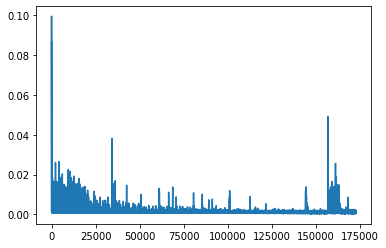

In [48]:
plt.plot(losses)

In [50]:
sequence, scaler = get_all_items_seq(tw=TRAIN_WINDOW)
sequence = [x[0] for x in sequence]
test_seq = sequence[-100]
model.eval()
predictions = []
for i in range(100):
  seq = test_seq[-TRAIN_WINDOW:].view(BATCH_SIZE, TRAIN_WINDOW, 500).cuda()
  with torch.no_grad():
    model.hidden = (torch.zeros(NUM_LAYERS,BATCH_SIZE, model.hidden_layer_size).cuda(),
                    torch.zeros(NUM_LAYERS,BATCH_SIZE, model.hidden_layer_size).cuda())
    test_seq = torch.cat((test_seq,model(seq).cpu().view(1,-1)), 0)
    y_hat = scaler.inverse_transform(np.array(model(seq).detach().cpu()).reshape(-1,1)).reshape(-1)
    predictions.append(y_hat)











100%|██████████| 1726/1726 [00:00<00:00, 147252.38it/s]


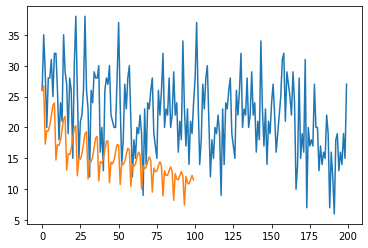

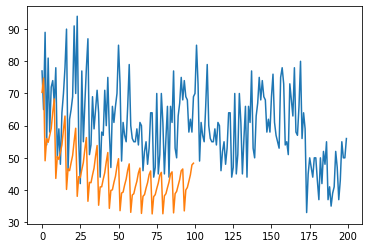

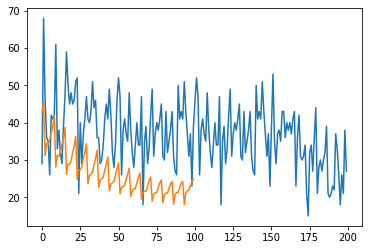

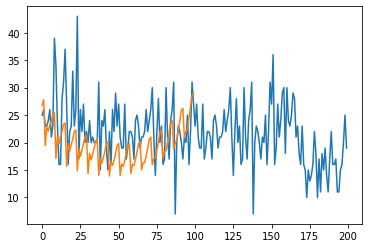

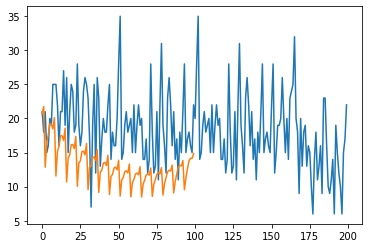

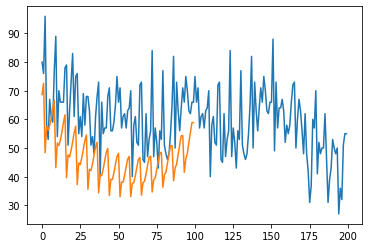

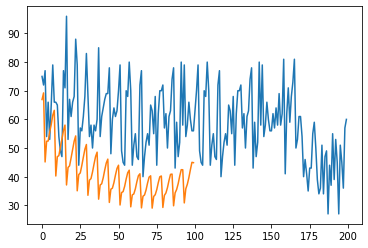

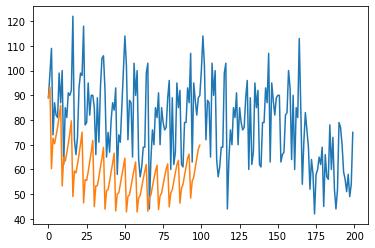

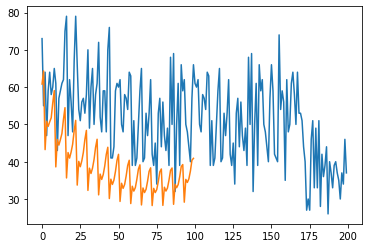

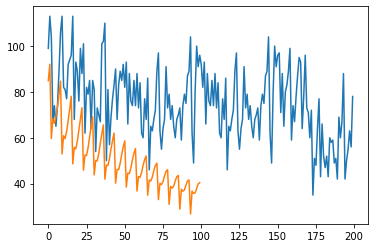

In [52]:
test_seq = torch.cat((sequence[-50], sequence[-1]), 0)
for i in range(10):
  random.randrange(0,499)
  item_1 = [x[i].item() for x in test_seq]
  item_1 = scaler.inverse_transform(np.array(item_1).reshape(-1,1)).reshape(-1)
  item_1_hat = [x[i] for x in predictions]
  plt.figure()
  plt.plot(item_1)
  plt.plot(item_1_hat)
  plt.show()

In [53]:
sequence, scaler = get_all_items_seq(tw = TRAIN_WINDOW)
sequence = [x[0] for x in sequence]
test_seq = sequence[-1]
model.eval()
predictions = []
for i in range(100):
  seq = test_seq[-TRAIN_WINDOW:].view(BATCH_SIZE, TRAIN_WINDOW, 500).cuda()
  with torch.no_grad():
    model.hidden = (torch.zeros(NUM_LAYERS,BATCH_SIZE, model.hidden_layer_size).cuda(),
                    torch.zeros(NUM_LAYERS,BATCH_SIZE, model.hidden_layer_size).cuda())
    test_seq = torch.cat((test_seq,model(seq).cpu().view(1,-1)), 0)
    y_hat = scaler.inverse_transform(np.array(model(seq).detach().cpu()).reshape(-1,1)).reshape(-1)
    predictions.append(y_hat)














100%|██████████| 1726/1726 [00:00<00:00, 137688.17it/s]


In [54]:
dates = pd.Series(pd.date_range(start='1/1/2018', end='3/31/2018')).repeat(500)
stores = pd.concat([pd.Series(range(1,11)).repeat(50)] *90)
items = pd.concat([pd.Series(range(1,51))] * 900)
dates.index = range(0,45000)
stores.index = range(0,45000)
items.index = range(0,45000)
sales = pd.Series(np.vstack(predictions).reshape(-1)[:45000])
submission = pd.DataFrame({'dates':dates, 'stores':stores, 'items':items, 'sales':sales})
submission = submission.sort_values(['items', 'stores', 'dates'], ascending=[True, True, True])
submission.index = range(0, 45000)
submission.to_csv('./all_output1.csv')